In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import collections
np.random.seed(0)
import itertools
from sklearn.metrics import accuracy_score
sns.set_theme(context='notebook')

<h1>
<span style="color:blue">1. Regularization and Hyper Parameter Tuning</span>.

<h2>A. Extending the Optimization Routines and Loss Functions

In [2]:
class Optimization(object):
    def __init__(self,X,y,loss):
        self.X = X
        self.y = y
        self.loss = loss
        
    def bold_driver(self,loss_old,loss_new,mu):
        if loss_new>loss_old:
            mu = mu/2
        elif loss_new<loss_old:
            mu = mu*1.1
        return mu
        
    def min_sgd(self, theta0, mu, C, K, lam):
        theta = theta0
        J_hist = np.zeros((K,1))
        theta_val = np.zeros((K,self.X.shape[1]))
        for i in range(K):
            for j in range(C):
                index = np.random.randint(len(self.y))
                xvar = self.X[index:index+1]
                yvar = self.y[index:index+1]
                losses, gradient, _ = self.loss(self, xvar, yvar,theta, lam)
                J_hist[i] += losses.ravel()
                mu = self.bold_driver(J_hist[j-1],J_hist[j],mu)
                theta = theta - mu*gradient
            J_hist[i] /= C       
            theta_val[i] = theta.reshape(1,self.X.shape[1])
        return J_hist, theta_val, theta

<h3> Bonus-ElasticNet, l1, l2, and balanced_cross_entropy

In [3]:
class Loss(Optimization):
    def __init__(self, X, y, lam):
        super().__init__()
        
    def mse(self, X, y, theta):          
        return ((X@theta-y)**2).mean(),X.T.dot(X.dot(theta) - y), X.T@X
        
    def cross_entropy(self, X,y, theta, lam=0):
        M = len(y)
        p = 1/(1+np.exp(-X@theta))
        W = np.diag((p*(1-p)).reshape(-1))
        return -1/M*(y.T@np.log(p) + (1-y).T@np.log((1-p))),-X.T.dot(y - p), X.T@W@X

    def l2(self, X,y, theta, lam):
        M = len(y)
        p = 1/(1+np.exp(-X@theta))
        W = np.diag((p*(1-p)).reshape(-1))
        return -1/M*(y.T@np.log(p) + (1-y).T@np.log((1-p)) + (lam/2)*np.dot(theta.T,theta)),-X.T.dot(y - p), X.T@W@X

    def l1(self, X,y, theta, lam):
        M = len(y)
        p = 1/(1+np.exp(-X@theta))
        W = np.diag((p*(1-p)).reshape(-1))
        return -1/M*(y.T@np.log(p) + (1-y).T@np.log((1-p)) + (lam/2)*np.sum(np.abs(theta))),-X.T.dot(y - p), X.T@W@X

    #ELASTIC NET
    def elasticnet(self, X,y, theta, lam):
        M = len(y)
        p = 1/(1+np.exp(-X@theta))
        W = np.diag((p*(1-p)).reshape(-1))
        return -1/M*(y.T@np.log(p) + (1-y).T@np.log((1-p)) + (lam/2)*np.sum(theta) + (lam/2)*np.dot(theta.T,theta)),-X.T.dot(y - p), X.T@W@X

    #The scalar factors in balanced_cross_entropy are found in a snippet later on and provided here directly, since they remain constant.
    def balanced_cross_entropy(self, X,y, theta, lam=0):
        M = len(y)
        p = 1/(1+np.exp(-X@theta))
        W = np.diag((p*(1-p)).reshape(-1))
        if y >= 0.5:
            gw = 1.341
        elif y == 0:
            gw = 0.796
        return -1/M*(0.796*y.T@np.log(p) + 1.341*(1-y).T@np.log((1-p))),(gw * -X.T.dot(y - p)), X.T@W@X

In [4]:
class LogisticRegression:

    def fit(self, X, y, learning_rate = 0.01, maxiter = 100, batch_size = 100, optimizer = 'SGD', lam=0):
        theta0 = np.zeros((X.shape[1],1))
        if optimizer == 'SGD':
            optimization = Optimization(X, y, loss = Loss.cross_entropy)
            J_hist, theta_val, theta  = optimization.min_sgd(theta0 = theta0,mu = learning_rate, C = batch_size,K = maxiter, lam=0)
        elif optimizer == 'BCE': #balanced_cross_entropy
            optimization = Optimization(X, y, loss = Loss.balanced_cross_entropy)
            J_hist, theta_val, theta = optimization.min_sgd(theta0 = theta0,mu = learning_rate, C = batch_size,K = maxiter, lam=0)
        elif optimizer == 'l1': #l1
            optimization = Optimization(X, y, loss = Loss.l1)
            J_hist, theta_val, theta  = optimization.min_sgd(theta0 = theta0,mu = learning_rate, C = batch_size,K = maxiter, lam=lam)
        elif optimizer == 'l2': #l2
            optimization = Optimization(X, y, loss = Loss.l2)
            J_hist, theta_val, theta  = optimization.min_sgd(theta0 = theta0,mu = learning_rate, C = batch_size,K = maxiter, lam=lam)
        elif optimizer == 'elasticnet':
            # BONUS ELASTICNET
            optimization = Optimization(X, y, loss = Loss.elasticnet)
            J_hist, theta_val, theta  = optimization.min_sgd(theta0 = theta0,mu = learning_rate, C = batch_size,K = maxiter, lam=lam)
        else: raise Exception("Please enter optimizer's name correctly: 'SGD' or 'BCE', 'l1', 'l2'")  
        self.theta = theta
        self.J_hist = J_hist
        self.theta_val = theta_val
        return theta, J_hist

    def predict(self, X, class_prob = False):
        if class_prob == True:
            return 1/(1+np.exp(-X@self.theta))
        else:
            return ((1/(1+np.exp(-X@self.theta)))>= 0.5).astype(int)

    def plot_loss(self, X, y):
        J_hist_pred = np.zeros((self.theta_val.shape[0],1))
        for i in range(self.theta_val.shape[0]):
            temp_theta = self.theta_val[i,:]
            p = 1/(1+np.exp(-X@temp_theta))
            J_hist_pred[i] = -1/len(y)*(y.T@np.log(p) + (1-y).T@np.log((1-p)))
        f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
        plt.figure(figsize=(10,5))
        ax0.plot(range(len(self.J_hist)), self.J_hist, 'blue')
        ax0.set_title("Cost Function of Train")
        ax0.set_xlabel("Number of Iterations")
        ax0.set_ylabel("Cost")
        ax1.plot(range(len(J_hist_pred)), J_hist_pred, 'red')
        ax1.set_title("Cost Function of Test")
        ax1.set_xlabel("Number of Iterations")
        ax1.set_ylabel("Cost")
        plt.show()
    def plot_metrics(self, y_true, y_pred):
        fp, fn, tp, tn = 0, 0, 0, 0
        for true, pred in zip(y_true, y_pred):
            if pred == true:
                if pred == 1: tp +=1
                else: tn+=1
            else:
                if pred == 1: fp +=1
                else: fn+=1
        confusion_matrix = np.array([[tp,fp], [fn, tn]])
        acolsuracy = np.round((tp+tn)/len(y_true),3)
        precision = np.round(tp/(tp+fp),3)
        recall = np.round(tp/(tp+fn),3)
        f1 = np.round((2*(precision*recall))/(precision + recall),3)
        print('-----------------------------------------------------------------------------------------------')
        print('|',f'Acolsuracy: {acolsuracy}','|' ,f'Recall: {recall}', ' |')
        print('|',f'Precision: {precision}','|', f'F1-score: {f1}', '|' )
        print('-----------------------------------------------------------------------------------------------')
        
        plt.figure(figsize=(8,5))
        sns.set(font_scale=1.4) 
        labels = ['1','0']
        sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 12}, fmt='g', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title('Confusion Matrix')
        plt.show()    

In [5]:
logistic = pd.read_csv('logistic.csv')
X = logistic.loc[:,'X1':'X30']
y = logistic.Y
x_scaled = (np.array(X) - np.mean(X, axis = 0).ravel())\
/(np.std(X,axis = 0).ravel())
x_scaled = np.hstack((np.ones((x_scaled.shape[0],1)),x_scaled))
x_scaled

mapping = {'M':1, 'B':0}
y = y.map(mapping)

<h4>#Computing weights for classes for balanced cross entropy

In [6]:
#Computing weights for classes for balanced cross entropy
mydict = collections.Counter(y)
mydict[0]
w0 = len(y)/(2*mydict[0])
w1 = len(y)/(2*mydict[1])
print('BALANCED_CROSS_ENTROPY weights are w0:{} and w1:{}'.format(w0,w1))

BALANCED_CROSS_ENTROPY weights are w0:0.7969187675070029 and w1:1.3419811320754718


In [7]:
mask = np.random.rand(len(x_scaled)) <= 0.80
training_data = x_scaled[mask]
testing_data = x_scaled[~mask]
training_y = y[mask]
testing_y = y[~mask]
print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")
training_y = training_y[:, np.newaxis]
testing_y = testing_y[:, np.newaxis]

No. of training examples: 458
No. of testing examples: 111


<h2>B. Regularization and Model Selection

<h3>Cross Entropy Loss and Stochastic Gradient Descent.

Train Results
-----------------------------------------------------------------------------------------------
| Acolsuracy: 0.932 | Recall: 0.932  |
| Precision: 0.896 | F1-score: 0.914 |
-----------------------------------------------------------------------------------------------


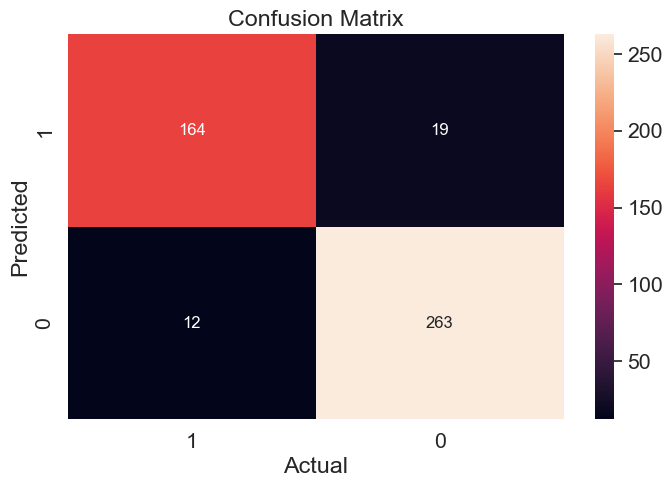

Test Results
-----------------------------------------------------------------------------------------------
| Acolsuracy: 0.91 | Recall: 0.861  |
| Precision: 0.861 | F1-score: 0.861 |
-----------------------------------------------------------------------------------------------


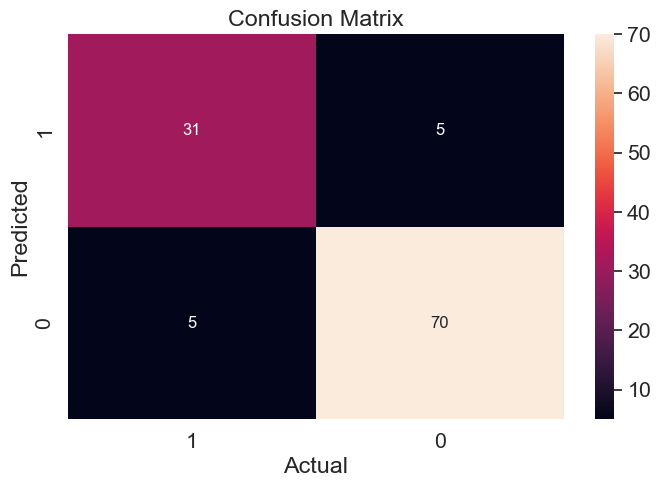

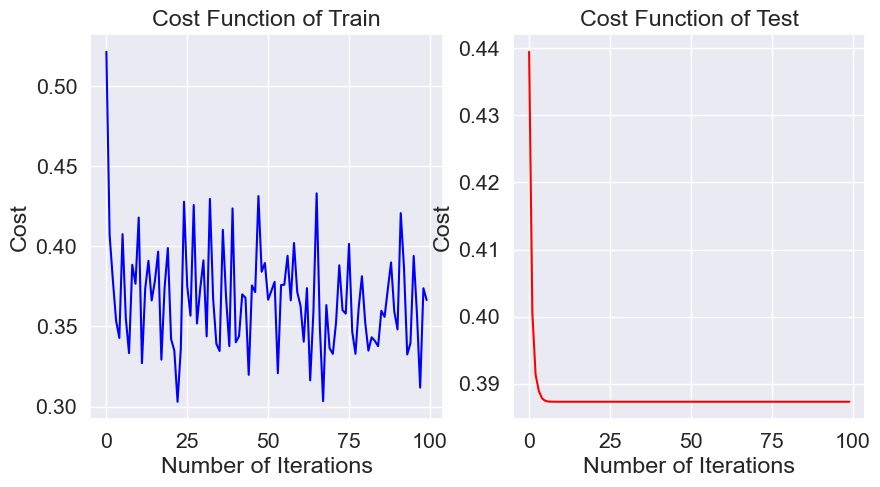

<Figure size 1000x500 with 0 Axes>

In [8]:
log_reg = LogisticRegression()
sgd_theta, _ = log_reg.fit(training_data, training_y,  learning_rate = 0.01, maxiter = 100, batch_size = 50, optimizer = 'SGD',lam=0)
pred_log = log_reg.predict(testing_data, class_prob = False)
print('Train Results')
pred_log_train= log_reg.predict(training_data)
log_reg.plot_metrics(training_y,pred_log_train)
print('Test Results')
pred_log = log_reg.predict(testing_data)
log_reg.plot_metrics(testing_y,pred_log)
#plotting
log_reg.plot_loss(testing_data, testing_y)

<h3>Balanced Cross Entropy Loss and Stochastic Gradient Descent.

Train Results
-----------------------------------------------------------------------------------------------
| Acolsuracy: 0.943 | Recall: 0.938  |
| Precision: 0.917 | F1-score: 0.927 |
-----------------------------------------------------------------------------------------------


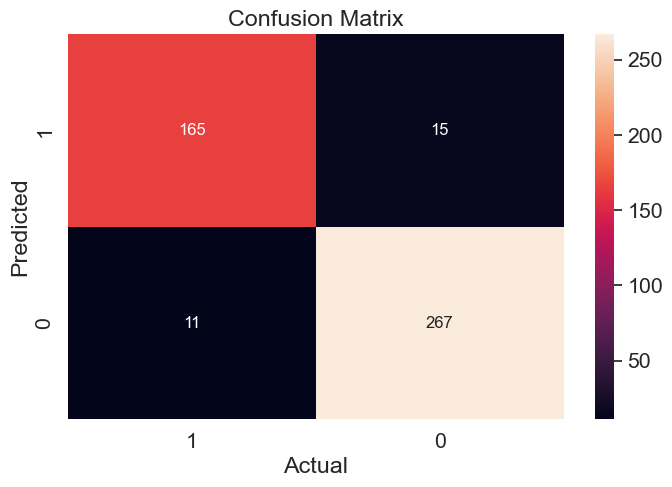

Test Results
-----------------------------------------------------------------------------------------------
| Acolsuracy: 0.937 | Recall: 0.889  |
| Precision: 0.914 | F1-score: 0.901 |
-----------------------------------------------------------------------------------------------


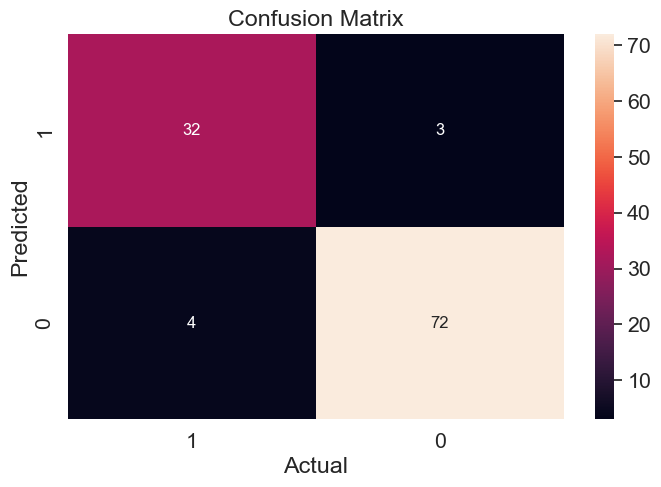

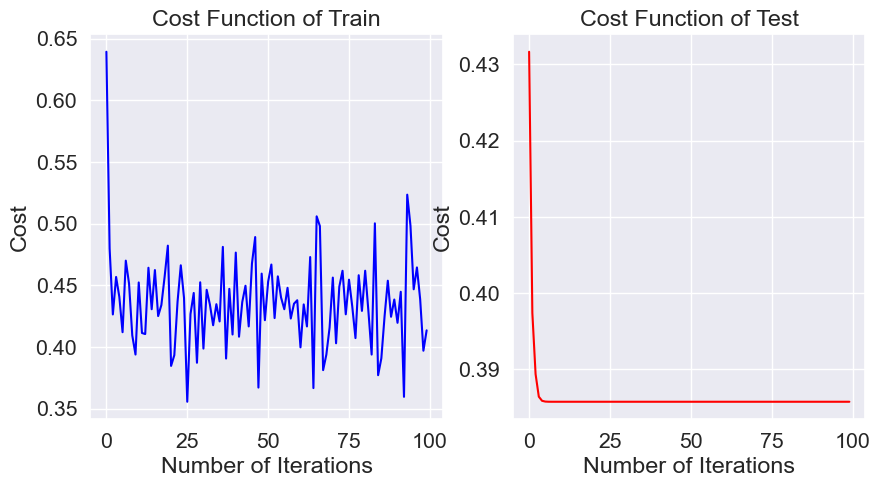

<Figure size 1000x500 with 0 Axes>

In [9]:
obj1 = LogisticRegression()
theta, _ = obj1.fit(training_data, training_y,  learning_rate = 0.01, maxiter = 100, batch_size = 50, optimizer = 'BCE',lam=0)
pred_log = obj1.predict(testing_data, class_prob = False)
print('Train Results')
pred_log_train= obj1.predict(training_data)
obj1.plot_metrics(training_y,pred_log_train)
print('Test Results')
pred_log = obj1.predict(testing_data)
obj1.plot_metrics(testing_y,pred_log)
#plotting
obj1.plot_loss(testing_data, testing_y)

<h3>L1-Regularized Cross Entropy Loss and Stochastic Gradient Descent.

Train Results
-----------------------------------------------------------------------------------------------
| Acolsuracy: 0.943 | Recall: 0.943  |
| Precision: 0.912 | F1-score: 0.927 |
-----------------------------------------------------------------------------------------------


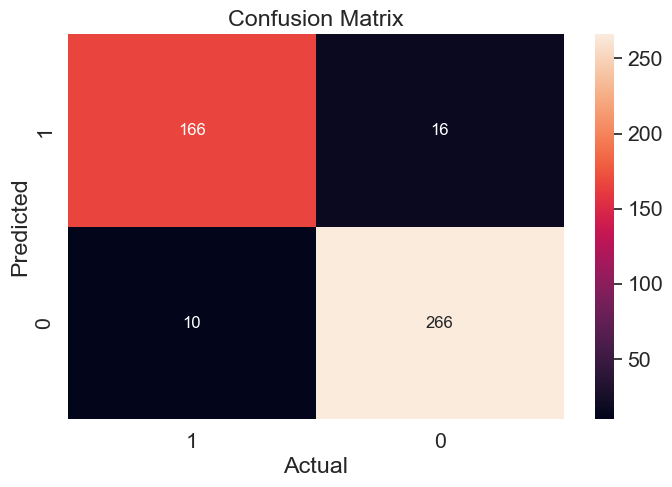

Test Results
-----------------------------------------------------------------------------------------------
| Acolsuracy: 0.919 | Recall: 0.861  |
| Precision: 0.886 | F1-score: 0.873 |
-----------------------------------------------------------------------------------------------


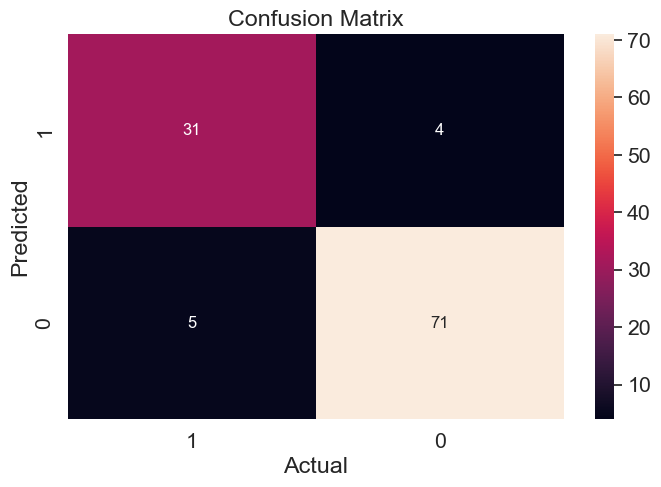

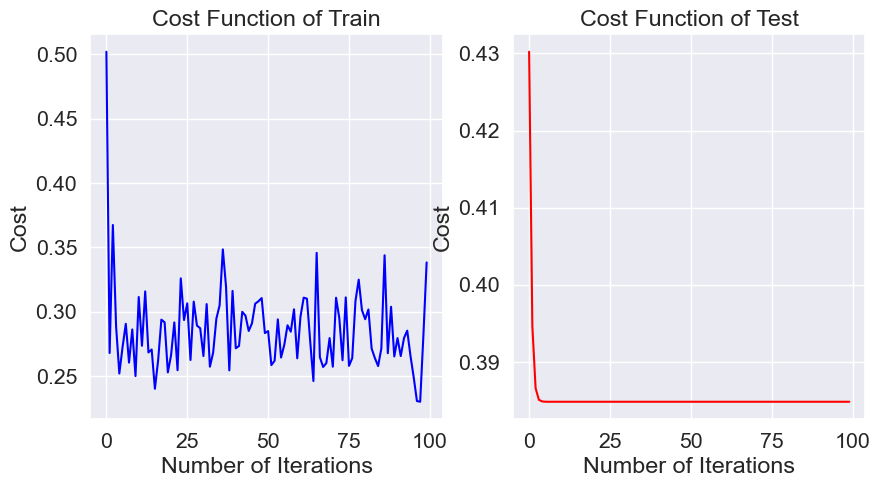

<Figure size 1000x500 with 0 Axes>

In [10]:
obj2 = LogisticRegression()
theta, _ = obj2.fit(training_data, training_y,  learning_rate = 0.01, maxiter = 100, batch_size = 50, optimizer = 'l1',lam=0.1)
pred_log = obj2.predict(testing_data, class_prob = False)
print('Train Results')
pred_log_train= obj2.predict(training_data)
obj2.plot_metrics(training_y,pred_log_train)
print('Test Results')
pred_log = obj2.predict(testing_data)
obj2.plot_metrics(testing_y,pred_log)
#plotting
obj2.plot_loss(testing_data, testing_y)

<h3> L2-Regularized Cross Entropy Loss and Stochastic Gradient Descent.

Train Results
-----------------------------------------------------------------------------------------------
| Acolsuracy: 0.939 | Recall: 0.932  |
| Precision: 0.911 | F1-score: 0.921 |
-----------------------------------------------------------------------------------------------


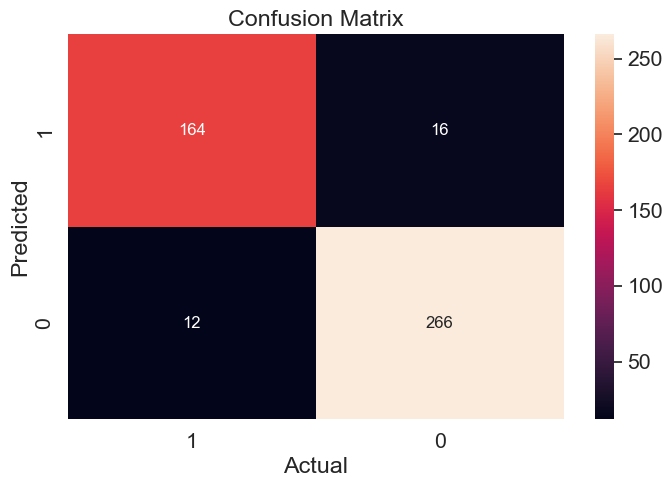

Test Results
-----------------------------------------------------------------------------------------------
| Acolsuracy: 0.937 | Recall: 0.889  |
| Precision: 0.914 | F1-score: 0.901 |
-----------------------------------------------------------------------------------------------


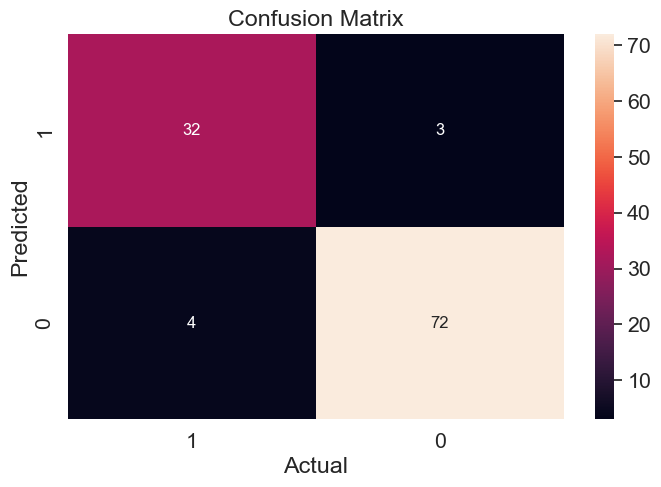

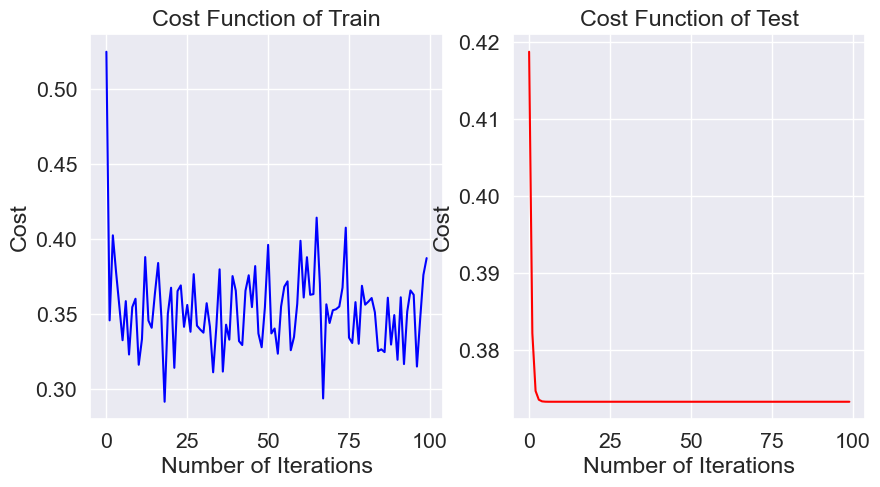

<Figure size 1000x500 with 0 Axes>

In [11]:
obj3 = LogisticRegression()
theta, _ = obj3.fit(training_data, training_y,  learning_rate = 0.01, maxiter = 100, batch_size = 50, optimizer = 'l2',lam=0.1)
pred_log = obj3.predict(testing_data, class_prob = False)
print('Train Results')
pred_log_train= obj3.predict(training_data)
obj3.plot_metrics(training_y,pred_log_train)
print('Test Results')
pred_log = obj3.predict(testing_data)
obj3.plot_metrics(testing_y,pred_log)
#plotting
obj3.plot_loss(testing_data, testing_y)

<h1>
<span style="color:blue">Akaike Information Criterion</span>.

<h4>Below performing aic computation by eliminating one column each time reducing the features by iterating backwards

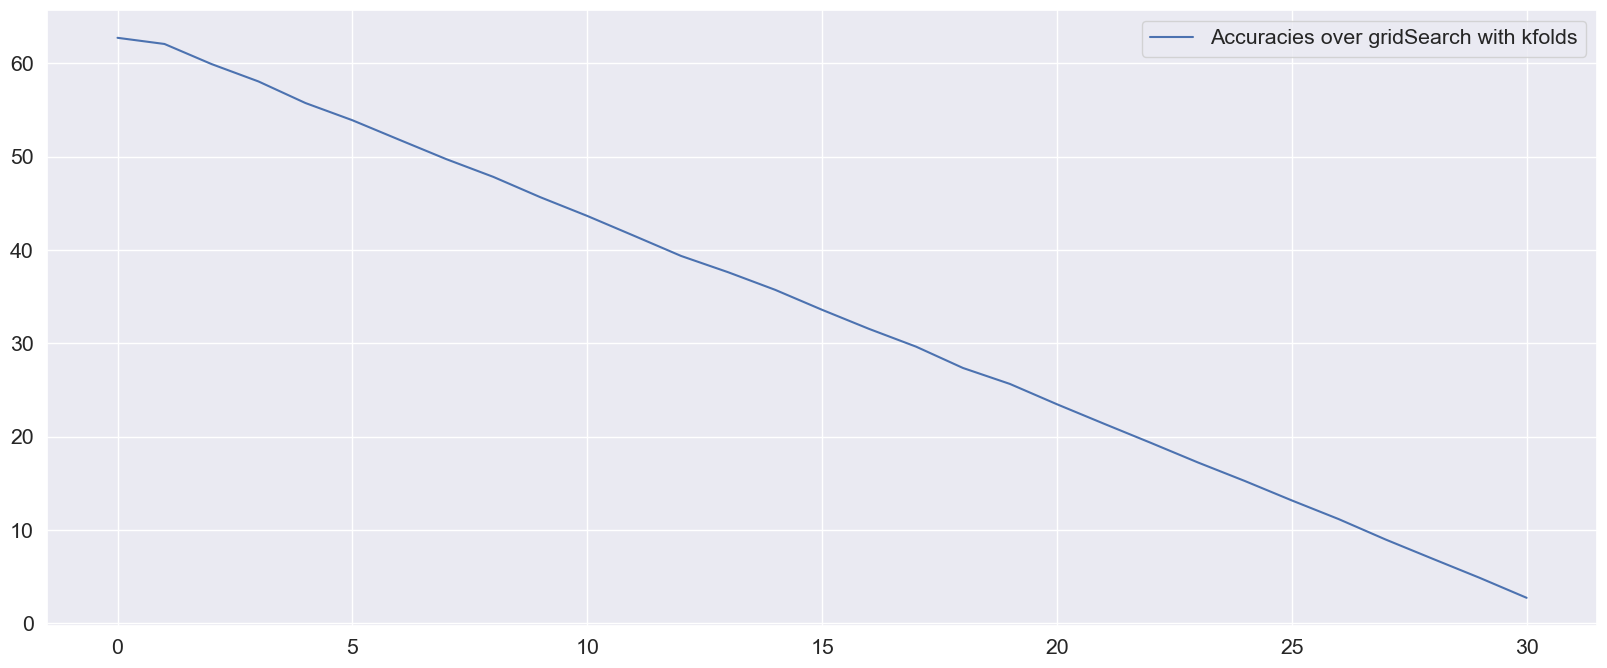

In [12]:
row, cols = training_data.shape
aicList = []
for i in range(cols):
    log_reg = None
    log_reg = LogisticRegression()
    train_data = training_data
    train_y = training_y
    train_data = train_data[:,:-i]
    _, J_hist = log_reg.fit(train_data, train_y,  learning_rate = 0.01, maxiter = 100, batch_size = 50, optimizer = 'SGD',lam=0)
    lastLoss = J_hist[-1]
    aic = -2* np.log(lastLoss) + 2*(cols-i)
    aicList.append((float(aic)))
# aicList.index(min(aicList))
plt.figure(figsize=(20,8))
sns.lineplot(aicList, label = 'Accuracies over gridSearch with kfolds')
plt.show()


<h4>Below performing aic computation by eliminating one column by iterating backward, hence each time we have #cols-1 for training

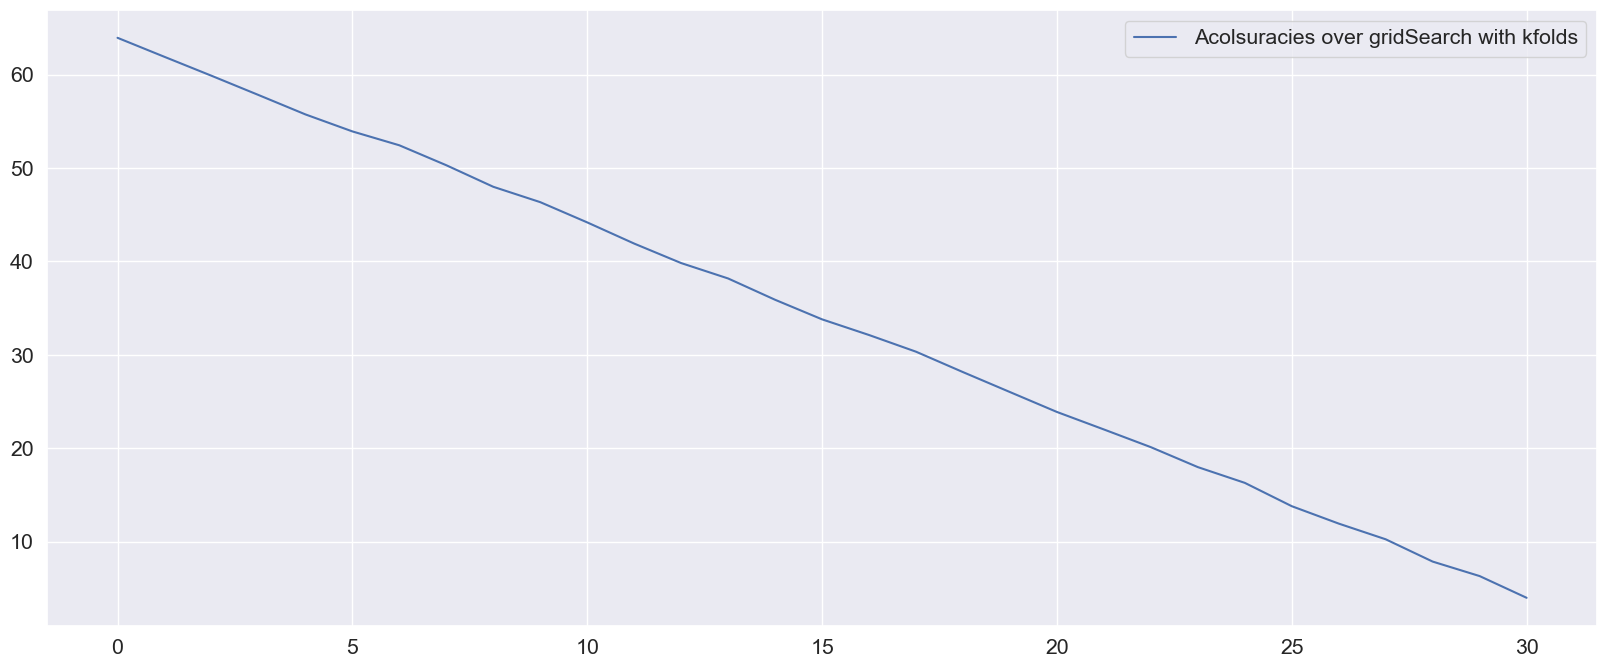

In [13]:
row, cols = training_data.shape
aicList = []
for i in range(cols):
    log_reg = None
    log_reg = LogisticRegression()
    train_data = training_data
    train_y = training_y
    train_data = np.delete(train_data, -i, axis=1)
    _, J_hist = log_reg.fit(train_data, train_y,  learning_rate = 0.01, maxiter = 100, batch_size = 50, optimizer = 'SGD',lam=0)
    lastLoss = J_hist[-1]
    aic = -2* np.log(lastLoss) + 2*(cols-i)
    aicList.append((float(aic)))
# aicList.index(min(aicList))
plt.figure(figsize=(20,8))
sns.lineplot(aicList, label = 'Acolsuracies over gridSearch with kfolds')
plt.show()


<h3><span style="color:blue">The above two methods are not accurate and do not provide insights on which features to keep and which to remove., hence manually computing t values, which will be used to compute p values. Any column with p value greater than 0.1 will be removed and the remaining columns are the ones which are the important features.</span>.

In [14]:
thetas = [float(x) for x in sgd_theta]
from scipy.stats import t
row, cols = training_data.shape
tlist =[]
plist = []
dof = cols-1
for i in range(cols):
    col = training_data[:,i]
    tt = np.mean(col) / (np.std(col)/np.sqrt(len(col)))
    p = 2*(t.cdf(-abs(tt), dof))
    plist.append(p)
goodCols = []
for i in range(len(plist)):
    if plist[i] <= 0.1:
        goodCols.append(i)
dataForAic = np.take(training_data, goodCols, axis=1)
print('As per the p values, the useful columns for our model are: ', goodCols)

As per the p values, the useful columns for our model are:  [0]


In [15]:
from scipy import stats
from scipy.stats import t
tlist =[]
plist = []
degrees_of_freedom = cols-1
rows, cols = training_data.shape
for i in range(cols):
    feature = training_data[:,i]
    mean = np.sum(feature)/len(feature)
    std_error = np.std(feature)/np.sqrt(len(feature))
    tt = (mean)/std_error #computing statistics
    tlist.append(tt)
    p = (1-stats.t.cdf(x=tt, df=degrees_of_freedom))#computing the p-value
    plist.append(p)
impColumns = []

#list of important features
for i in range(len(plist)):
    if plist[i] <= 0.3:
        impColumns.append(i)

print("t-values:\n",tlist,"\n")
print("p-values:\n",plist)
print('As per the p values, the useful columns for our model are: ', impColumns)

t-values:
 [inf, 0.3235225417820746, -0.18529781958465272, 0.31853180885246946, 0.27880605210637555, 0.32568456159559406, -0.010271715302343354, -0.08485768918489543, 0.25133475291667373, 0.031274381413425166, -0.3100397563172318, -0.05412762260471479, -0.0664980268179535, -0.053551916885249046, 0.031755166666567206, -0.41119104691298297, -0.1659072197122578, -0.4911038661859098, -0.11557257399651438, 0.6021877039490922, 0.04691495446611483, 0.3413130233225357, 0.02946004667449403, 0.36436450745939897, 0.2619040488167825, 0.22960446723117034, -0.012761626938890809, -0.317634971652005, 0.2765030052862337, 0.5700999074572284, -0.1583665175890385] 

p-values:
 [0.0, 0.37427204460382946, 0.572878722862873, 0.3761443226405603, 0.3911532986199062, 0.37346192395770084, 0.5040637473258951, 0.5335308477945124, 0.40163448418346004, 0.48762893205033553, 0.6206628480940061, 0.5214038294948957, 0.5262887384327852, 0.5211764026361302, 0.4874388155125471, 0.6580724342425184, 0.5653284886885729, 0.686

<h4> 
<span style="color:blue">Performing SGD with cross_entropy on the important features to see the performance.</span>

Train Results
-----------------------------------------------------------------------------------------------
| Acolsuracy: 0.699 | Recall: 0.392  |
| Precision: 0.69 | F1-score: 0.5 |
-----------------------------------------------------------------------------------------------


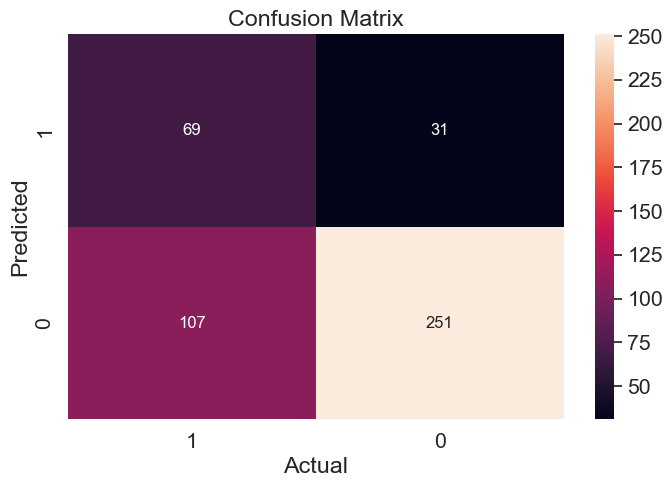

Test Results
-----------------------------------------------------------------------------------------------
| Acolsuracy: 0.694 | Recall: 0.25  |
| Precision: 0.562 | F1-score: 0.346 |
-----------------------------------------------------------------------------------------------


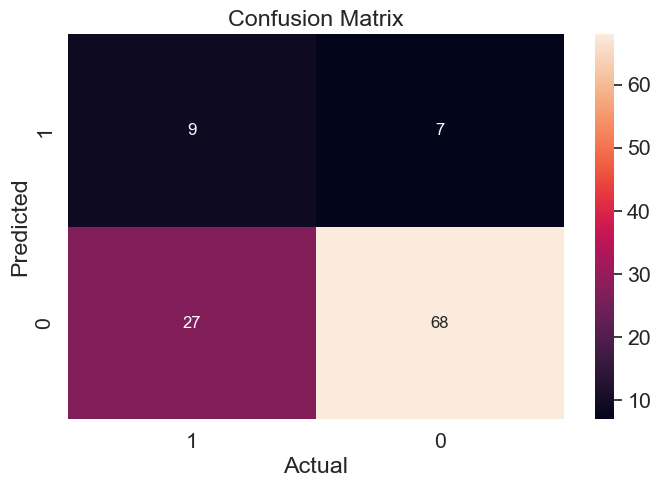

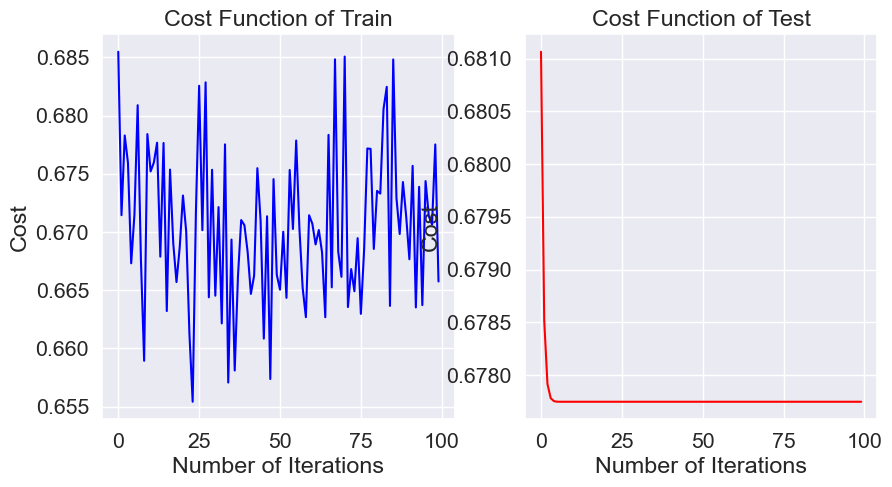

<Figure size 1000x500 with 0 Axes>

In [16]:
aicTesting = np.take(testing_data, impColumns, axis=1)
dataForAic = np.take(training_data, impColumns, axis=1)
log_reg = LogisticRegression()
theta, J_hist= log_reg.fit(dataForAic, training_y,  learning_rate = 0.01, maxiter = 100, batch_size = 50, optimizer = 'SGD',lam=0)
pred_log = log_reg.predict(aicTesting, class_prob = False)
print('Train Results')
pred_log_train= log_reg.predict(dataForAic)
log_reg.plot_metrics(training_y,pred_log_train)
print('Test Results')
pred_log = log_reg.predict(aicTesting)
log_reg.plot_metrics(testing_y,pred_log)
# plotting
log_reg.plot_loss(aicTesting, testing_y)

In [17]:
AIC = 2*31 - 2*J_hist[-1]

<h1> 
<span style="color:blue">KFOLD with GridSearch</span>

<h3><span style="color:blue">Below I perform a gridsearch with all pairs for alpha and lambda values specified below. For each pair the kfolds algorithm runs, 3 times in our case. It computes the accuracy and fid the mean accuracy for each of the alpha, lambda pair. Next, the best performing pair of alpha, lambda, i.e which provides best mean kfolds accuracy is selected and printed.</span>.

In [18]:
def gridsearch_kfolds(x_scaled, y, k = 3):
    alpha = np.arange(0.1,1,0.1)
    lam = np.arange(0.01,0.1,0.01)
    c = list(itertools.product(alpha, lam))
    len(c)

    y = y.to_numpy()
    y.shape = (len(y),1)
    joined = np.hstack((x_scaled,y))
    np.random.shuffle(joined)
    splits = np.array_split(joined, k)

    meanAcolss = []
    for a,l in c:
        kfoldAcolss = []
        kfoldparams = []
        for i in range(len(splits)):
            getTest = splits[i]
            stackChunks = np.arange(k)
            stackChunks = np.delete(stackChunks, i)
            getChunks = np.take(splits, stackChunks)
            stacked = np.concatenate(getChunks)
            training_data = stacked[:,:-1]
            testing_data = getTest[:,:-1]
            training_y = stacked[:,-1]
            testing_y = getTest[:,-1]

            pred_log = None
            # print('Using params a,l: ', a,l)
            obj = LogisticRegression()
            theta, _ = obj.fit(training_data, training_y,  learning_rate = a, maxiter = 300, batch_size = 10, optimizer = 'l2', lam = l)
            pred_log = obj.predict(testing_data, class_prob = False)
            pred_log_train= obj.predict(training_data)
            pred_log = obj.predict(testing_data)

            acc = accuracy_score(testing_y, pred_log)
            kfoldAcolss.append(acc)
            kfoldparams.append((a,c))
        meanAcolss.append(np.mean(kfoldAcolss))
    return meanAcolss, c

In [19]:
meanAcc, c = gridsearch_kfolds(x_scaled, y, k=3)

In [20]:
print('Best mean accuracy from kfolds is: {} for the gridsearch alpha, lambda pair: {}'.format(max(meanAcc), c[meanAcc.index(max(meanAcc))]))

Best mean accuracy from kfolds is: 0.9701383087347999 for the gridsearch alpha, lambda pair: (0.4, 0.01)


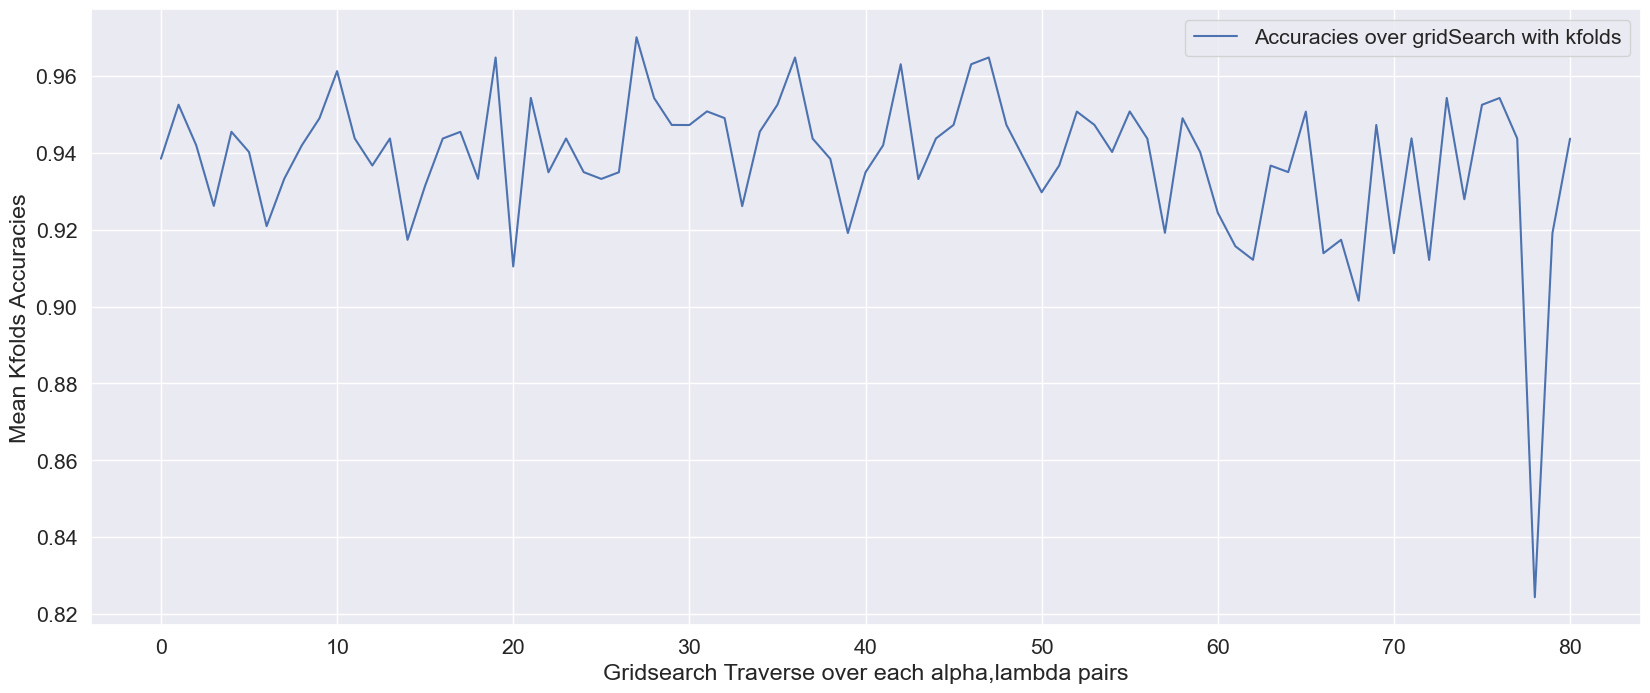

In [21]:
plt.figure(figsize=(20,8))
sns.lineplot(meanAcc, label = 'Accuracies over gridSearch with kfolds')
plt.xlabel('Gridsearch Traverse over each alpha,lambda pairs')
plt.ylabel('Mean Kfolds Accuracies')
plt.show()

<h2>
<span style="color:blue">Find below the 2 variants for 3d plots</span>

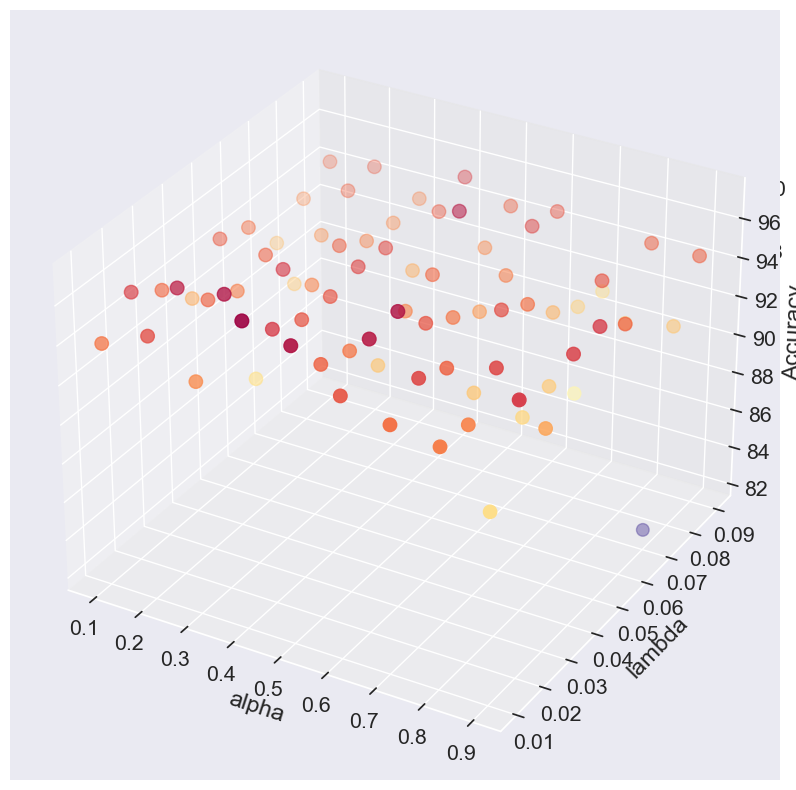

In [22]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax = plt.axes(projection='3d')

xdata = [x[0] for x in c]
ydata = [x[1] for x in c]
zdata = np.multiply(meanAcc, 100)
size =np.multiply(meanAcc, 100)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap=plt.cm.Spectral_r, s=size)
ax.set_xlabel('alpha')
ax.set_ylabel('lambda')
ax.set_zlabel('Accuracy')

plt.show()

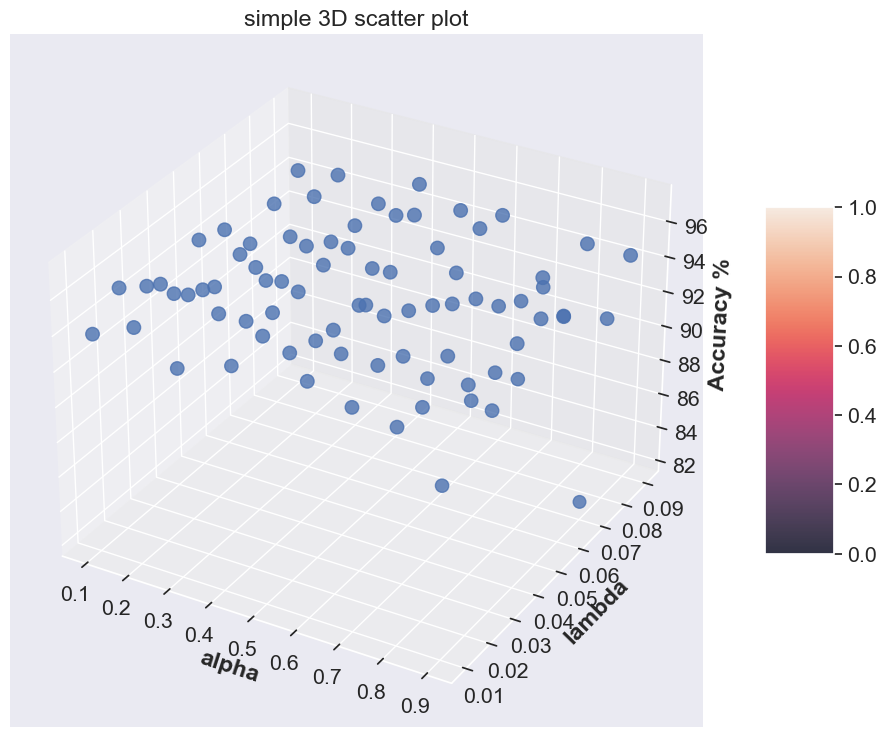

In [23]:
# Import libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

x = [x[0] for x in c]
y = [x[1] for x in c]
z = np.multiply(meanAcc, 100)

# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")

# Add x, y gridlines
ax.grid(b = True, color ='grey',
		linestyle ='-.', linewidth = 0.3,
		alpha = 0.2)

size =np.multiply(meanAcc, 100)
# Creating plot
sctt = ax.scatter3D(x, y, z,
					alpha = 0.8,
					cmap = plt.cm.Spectral_r,
					s=size)

plt.title("simple 3D scatter plot")
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
ax.set_xlabel('alpha')
ax.set_ylabel('lambda')
ax.set_zlabel('Accuracy %')
plt.show()
